# Logistic Regression with a Neural Network Mindset

Welcome to your first (required) programming assignment! You will build a logistic regression classifier to recognize  cats. This assignment will step you through how to do this with a Neural Network mindset, and so will also hone your intuitions about deep learning.

**Instructions:**
- Do not use loops (```for```/```while```) in your code, unless the instructions explicitly ask you to do so.

**You will learn to:**
- Build the general architecture of a learning algorithm, including:
    - Initializing parameters
    - Calculating the cost function and its gradient
    - Using an optimization algorithm (gradient descent) 
- Gather all three functions above into a main model function, in the right order.

## 1 - Packages 

In [3]:
using HDF5
using PyPlot
using LaTeXStrings
using LinearAlgebra
using Statistics
using Printf

## 2 - Overview of the Problem Set

**Problem Statement**: You are given a dataset ("```data.h5```") containing:
- a training set of ```m_train``` images labeled as cat (```y=1```) or non-cat (```y=0```)
- a test set of ```m_test``` images labeled as cat or non-cat
- each image is of shape ```(num_px, num_px, 3)``` where ```3``` is for the $3$ channels (RGB). Thus, each image is square (```height = num_px```) and (```width = num_px```).

You will build a simple image-recognition algorithm that can correctly classify pictures as cat or non-cat.

Let's get more familiar with the dataset. Notice that in Julia, to read a Hierarchical Data Format (HDF) file, we need to use ```fid = h5open(filename, mode)```, in which ```filename``` is a string and the ```mode``` can be any one of the following:

|mode        |Meaning   |
|------------|----------|
|```"r"```   |read-only |
|```"r+"```  |read-write, preserving any existing contents |
|```"cw"```  |read-write, create file if not existing, preserve existing contents |
|```"w"```   |read-write, destroying any existing contents (if any)|

See more information on [HDF5.jl](https://juliaio.github.io/HDF5.jl/stable/).

Load the data by running the following code.

In [2]:
# Load the training data
fid_train = h5open("./datasets/train_catvnoncat.h5", "r")
@show keys(fid_train)

# Get train_set_x_orig and train_set_y
train_set_x_orig = Int.(fid_train["train_set_x"][:, :, :, :]) # size(train_set_x_orig) = (3, 64, 64, 209)
train_set_x_orig = permutedims(train_set_x_orig, [4, 3, 2, 1]) # size(train_set_x_orig) = (209, 64, 64, 3)
train_set_y_orig = Int.(fid_train["train_set_y"][:]) # size(train_set_y_orig) = (209,)
train_set_y = reshape(train_set_y_orig, (1, length(train_set_y_orig))) # size(train_set_y) = (1, 209)

@show size(train_set_x_orig);

keys(fid_train) = ["list_classes", "train_set_x", "train_set_y"]
size(train_set_x_orig) = (209, 64, 64, 3)


In [3]:
# Load the test set
fid_test = h5open("./datasets/test_catvnoncat.h5","r")
@show keys(fid_test)

# Get test_set_x_orig and test_set_y
test_set_x_orig = Int.(fid_test["test_set_x"][:, :, :, :]) # size(test_set_x_orig) = (3, 64, 64, 50)
test_set_x_orig = permutedims(test_set_x_orig, [4, 3, 2, 1]) # size(test_set_x_orig) = (50, 64, 64, 3)
test_set_y_orig = Int.(fid_test["test_set_y"][:]) # size(test_set_y_orig) = (50,)
test_set_y = reshape(test_set_y_orig, (1, length(test_set_y_orig))); # size(test_set_y) = (1, 50)

keys(fid_test) = ["list_classes", "test_set_x", "test_set_y"]


In [4]:
# Get the classes
classes = string.(fid_test["list_classes"][:])
@show classes;

classes = ["non-cat", "cat"]


We added "```_orig```" at the end of image datasets (train and test) because we are going to preprocess them. After preprocessing, we will end up with ```train_set_x``` and ```test_set_x``` (the labels ```train_set_y``` and ```test_set_y``` don't need any preprocessing).

Each line of your ```train_set_x_orig``` and ```test_set_x_orig``` is an array representing an image. You can visualize an example by running the following code. Feel free also to change the ```index``` value and re-run to see other images. 

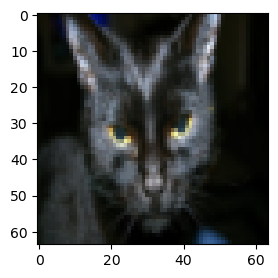

y = 1, it's a cat picture.


In [5]:
# Example of a picture
index =  26
plt.figure(figsize=(3,3))
plt.imshow(train_set_x_orig[index, :, :, :])
println("y = " * string(train_set_y[index]) * ", it's a " * classes[(train_set_y[index])+1] *  " picture.")
# y=0 -> non-cat (index 1) & y=1 -> cat (index 2)

Many software bugs in deep learning come from having matrix/vector dimensions that don't fit. If you can keep your matrix/vector dimensions straight you will go a long way toward eliminating many bugs. 

**Exercise:** Find the values for:
    - ```m_train``` (number of training examples)
    - ```m_test``` (number of test examples)
    - ```num_px``` (= ```height``` = ```width``` of a training image)
Remember that `train_set_x_orig` is an array of shape ```(m_train, num_px, num_px, 3)```. For instance, you can access `m_train` by writing `size(train_set_x_orig)[0]`.

In [6]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = size(train_set_x_orig)[1]
m_test = size(test_set_x_orig)[1]
num_px = size(train_set_x_orig)[2]
### END CODE HERE ###

println("Number of training examples: m_train = " * string(m_train))
println("Number of testing examples: m_test = " * string(m_test))
println("Height/Width of each image: num_px = " * string(num_px))
println("Each image is of size: (" * string(num_px) * ", " * string(num_px) * ", 3)")
println("train_set_x shape: " * string(size(train_set_x_orig)))
println("train_set_y shape: " * string(size(train_set_y)))
println("test_set_x shape: " * string(size(test_set_x_orig)))
println("test_set_y shape: " * string(size(test_set_y)))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


**Expected Output for ```m_train```, ```m_test``` and ```num_px```**: 

| ```m_train``` | ```m_test``` | ```num_px``` |
|---------------|--------------|--------------|
| 209           | 50           | 64           |

For convenience, you should now reshape images of shape ```(num_px, num_px, 3)``` in an array of shape ```(num_px*num_px*3, 1)```. After this, our training (and test) dataset is an array where each column represents a flattened image. There should be ```m_train``` (respectively ```m_test```) columns.

**Exercise:** Reshape the training and test data sets so that images of size ```(num_px, num_px, 3)``` are flattened into single vectors of shape ```(num_px*num_px*3, 1)```.

A trick when you want to flatten a matrix ```X``` of shape ```(a,b,c,d)``` to a matrix ```X_flatten``` of shape ```(b*c*d, a)``` is to use: 

```julia
    X_flatten = reshape(X, (a, b*c*d))'
```

But if you want to get the same matrices as those you have got in Python, you have to use

```julia
    temp = permutedims(X, [1, 4, 3, 2])
    X_flatten = reshape(temp, (a, b*c*d))'
```

This is because Julia and Python Numpy have different machanisms in implementing ```reshape```. Julia gives priority to the last index, while Numpy prioritizes the first index. For example, in Julia

```julia
    a = [[1 2 3]; [4 5 6]]
    reshape(a, (6,1))

    6×1 Array{Int64,2}:
     1
     4
     2
     5
     3
     6
```

while in Python, 

```python
    a = np.array([[1,2,3],[4,5,6]])
    a.reshape((6,1))

    array([[1],
           [2],
           [3],
           [4],
           [5],
           [6]])
```

The essential cause of these different results is that Numpy stores arrays in row-major manner, but Julia stores arrays in column-major manner.

In [7]:
# reshape the array directly
train_set_x_flatten = reshape(train_set_x_orig, (m_train, num_px*num_px*3))'

12288×209 Adjoint{Int64,Array{Int64,2}}:
 17  196   82   1   9   84  56  19  …   43  102   93  200   9  143  22   8
 25  230   95   1   9   99  56   7      48  117   99  136  10  151  22  15
 32  232   94   1   9  110  53   6      56  108  103  179   9  204  22  20
 36  217   96   2   8  103  58   6      65  108  108  197  10  196  21  21
 40  237   99   2   9   57  51   6      50  113  113  132  10  202  21  22
 41  238   94   2   8   60  53   6  …   47   91  115  100  11  173  22  23
 43  215   98   2   7   77  45   5      59  105  117  105  12  139  21  22
 46  178  101   1   8   84  42   6      55  146  119  120  12  143  20  22
 50  170  103   1   8   75  40   6      51  123  121  114  15  180  20  25
 53  178  109   1   8   43  40   6      47   39  124  105  18  194  18  26
 56  187  103   2   7   43  53   8  …   48   18  126  112  23  192  16  28
 58  188  105   2   7   86  55   8      54   31  125  126  28  191  12  29
 60  198  117   3   7   41  53  10      61   30  124  114  

In [8]:
# permute the indices first then reshape the array
bar_train_set_x_temp = permutedims(train_set_x_orig, [1, 4, 3, 2])
bar_train_set_x_flatten = reshape(train_set_x_temp, (m_train, num_px*num_px*3))' 

LoadError: UndefVarError: train_set_x_temp not defined

It can be seen that the arrays differ in the order of column elements, which means generally, $X^{(i)}_j \neq \bar{X}^{(i)}_j$, $\forall i \in \{1, \cdots, m\}$, $\forall j \in \{1, \cdots n_x\}$, but the two sets $\{X^{(i)}_1, \cdots X^{(i)}_{n_x}\}$ and $\{\bar{X}^{(i)}_1, \cdots, \bar{X}^{(i)}_{n_x}\}$ are equal.

Theoretically, no matter which way you use to reshape the array, the results should be the same, because what you did is just change the alignment of variables $x_1, \cdots, x_{n_x}$. 

In [9]:
# Reshape the training and test examples

### START CODE HERE ### (≈ 4 lines of code)
train_set_x_flatten = reshape(permutedims(train_set_x_orig, [1, 4, 3, 2]), (m_train, num_px*num_px*3))' 
test_set_x_flatten = reshape(permutedims(test_set_x_orig, [1, 4, 3, 2]), (m_test, num_px*num_px*3))' 
### END CODE HERE ###

println("train_set_x_flatten shape: " * string(size(train_set_x_flatten)))
println("train_set_y shape: " * string(size(train_set_y)))
println("test_set_x_flatten shape: " * string(size(test_set_x_flatten)))
println("test_set_y shape: " * string(size(test_set_y)))
println("sanity check after reshaping: " * string(train_set_x_flatten[1:6, 1]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17, 31, 56, 22, 33, 59]


**Expected Output**: 

| ```train_set_x_flatten shape``` | ```train_set_y shape``` | ```test_set_x_flatten shape``` | ```test_set_y shape``` | sanity check after reshaping |
|---------------------------------|-------------------------|-------------------------------:|------------------------|------------------------------|
| ```(12288, 209)```              | ```(1, 209)```          |              ```(12288, 50)``` | ```(1, 50)```          | ```[17, 31, 56, 22, 33, 59]```       |

To represent color images, the red, green and blue channels (RGB) must be specified for each pixel, and so the pixel value is actually a vector of three numbers ranging from 0 to 255.

One common preprocessing step in machine learning is to center and standardize your dataset, meaning that you substract the mean of the whole numpy array from each example, and then divide each example by the standard deviation of the whole numpy array. But for picture datasets, it is simpler and more convenient and works almost as well to just divide every row of the dataset by 255 (the maximum value of a pixel channel).

During the training of your model, you're going to multiply weights and add biases to some initial inputs in order to observe neuron activations. Then you backpropogate with the gradients to train the model. But, it is extremely important for each feature to have a similar range such that our gradients don't explode. You will see that more in detail later in the lectures.

Let's standardize our dataset.

In [10]:
train_set_x = train_set_x_flatten ./ 255
test_set_x = test_set_x_flatten ./ 255;

**What you need to remember:**

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem ```(m_train, m_test, num_px, ...)```
- Reshape the datasets such that each example is now a vector of size ```(num_px * num_px * 3, 1)```
- "Standardize" the data

## 3 - General Architecture of the Learning Algorithm

It's time to design a simple algorithm to distinguish cat images from non-cat images.

You will build a Logistic Regression, using a Neural Network mindset. The following Figure explains why **Logistic Regression is actually a very simple Neural Network!**

<img src="images/LogReg_kiank.png" style="width:650px;height:400px;">

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = \text{sigmoid}(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

**Key steps**:
In this exercise, you will carry out the following steps: 

- Initialize the parameters of the model
- Learn the parameters for the model by minimizing the cost  
- Use the learned parameters to make predictions (on the test set)
- Analyse the results and conclude

## 4 - Building the Parts of Our Algorithm

The main steps for building a Neural Network are:
1. Define the model structure (such as number of input features) 
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

You often build 1-3 separately and integrate them into one function we call `model()`.

### 4.1 - A Helper Function

**Exercise**: Implement ```sigmoid()```. As you've seen in the figure above, you need to compute $\sigma( w^T x + b) = \frac{1}{1 + e^{-(w^T x + b)}}$ to make predictions.

In [11]:
# GRADED FUNCTION: sigmoid
"""
Compute the sigmoid of z

Arguments:
z -- A scalar or array of any size.

Return:
s -- sigmoid(z)
"""
function sigmoid(z)
    
    ### START CODE HERE ### (≈ 1 line of code)
    s = 1 ./ (1 .+ exp.(-z))
    ### END CODE HERE ###
    
    return s
end

sigmoid

In [12]:
println("sigmoid([0, 2]) = " * string(sigmoid([0, 2])))

sigmoid([0, 2]) = [0.5, 0.8807970779778823]


**Expected Output**: 

|**sigmoid([0, 2])**|
|------------------------|
|```[0.5, 0.88079708]```|

### 4.2 - Initializing Parameters

**Exercise:** Implement parameter initialization in the cell below. You have to initialize ```w``` as a vector of zeros.

In [13]:
# GRADED FUNCTION: initialize_with_zeros
"""
This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

Argument:
dim -- size of the w vector we want (or number of parameters in this case)

Returns:
w -- initialized vector of shape (dim, 1)
b -- initialized scalar (corresponds to the bias)
"""
function initialize_with_zeros(dim)

    ### START CODE HERE ### (≈ 1 line of code)
    w = zeros((dim, 1))
    b = 0
    ### END CODE HERE ###

    @assert size(w) == (dim, 1)
    @assert isa(b, Float64) | isa(b, Int)
    
    return w, b
end

initialize_with_zeros

In [14]:
dim = 2
w, b = initialize_with_zeros(dim)
println("w = " * string(w))
println("b = " * string(b))

w = [0.0; 0.0]
b = 0


**Expected Output**: 

|**w**|**b**|
|-----|-----|
|```[0.0; 0.0]```|```0```|

For image inputs, ```w``` will be of shape $(\text{num_px} \times \text{num_px} \times 3, 1)$.

### 4.3 - Forward and Backward Propagation

Now that your parameters are initialized, you can do the "forward" and "backward" propagation steps for learning the parameters.

**Exercise:** Implement a function `propagate()` that computes the cost function and its gradient.

**Hints**:

Forward Propagation:
- You get $X$
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas you will be using: 

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$

In [15]:
# GRADED FUNCTION: propagate
"""
Implement the cost function and its gradient for the propagation explained above.

Arguments:
w -- weights, an array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of size (num_px * num_px * 3, number of examples)
Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

Return:
cost -- negative log-likelihood cost for logistic regression
dw -- gradient of the loss with respect to w, thus same shape as w
db -- gradient of the loss with respect to b, thus same shape as b

Tips:
- Write your code step by step for the propagation. log(), dot()
"""
function propagate(w, b, X, Y)
    
    m = size(X)[2]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid((w' * X) .+ b)                                      # compute activation
    cost = - 1/m * (dot(Y, log.(A)) + dot(1 .- Y, log.(1 .- A)))    # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = 1/m * (X * (A .- Y)')
    db = 1/m * sum(A .- Y)
    ### END CODE HERE ###
    @assert size(dw) == size(w)
    @assert isa(db, Float64)
    @assert size(cost) == ()
    
    grads = Dict("dw" => dw, "db"=> db)
    
    return grads, cost
end

propagate

In [16]:
w, b, X, Y = [[1.]; [2.]], 2., [[1. 2. -1.]; [3. 4. -3.2]], [1 0 1]
w = reshape(w, (length(w), 1))
Y = reshape(Y, (1, length(Y)))
grads, cost = propagate(w, b, X, Y)
println("dw = " * string(grads["dw"]))
println("db = " * string(grads["db"]))
println("cost = " * string(cost))

dw = [0.998456014637956; 2.3950723884862066]
db = 0.001455578136784208
cost = 5.801545319394553


**Expected Output**:

|**dw**|**db**|**cost**|
|------|------|--------|
|```[0.998456014637956; 2.3950723884862066]```|```0.001455578136784208```|```5.801545319394553```|

### 4.4 - Optimization

- You have initialized your parameters.
- You are also able to compute a cost function and its gradient.
- Now, you want to update the parameters using gradient descent.

**Exercise:** Write down the optimization function. The goal is to learn $w$ and $b$ by minimizing the cost function $J$. For a parameter $\theta$, the update rule is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate.

In [17]:
# GRADED FUNCTION: optimize
"""
This function optimizes w and b by running a gradient descent algorithm

Arguments:
w -- weights, a numpy array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of shape (num_px * num_px * 3, number of examples)
Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
num_iterations -- number of iterations of the optimization loop
learning_rate -- learning rate of the gradient descent update rule
print_cost -- True to print the loss every 100 steps

Returns:
params -- dictionary containing the weights w and bias b
grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
costs -- list of all the costs computed during the optimization, 
         this will be used to plot the learning curve.

Tips:
You basically need to write down two steps and iterate through them:
    1) Calculate the cost and the gradient for the current parameters. Use propagate().
    2) Update the parameters using gradient descent rule for w and b.
"""
function optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = false)
    
    costs = []
    dw = 0 # initialize dw
    db = 0 # initialize db
    
    for i in 1: num_iterations
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w .- learning_rate.*dw
        b = b .- learning_rate.*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0
            append!(costs, cost)
        end
        # Print the cost every 100 training iterations
        if print_cost && i % 100 == 0
            println("Cost after iteration $(i): $(cost)")
        end      
    end
    
    grads = Dict("dw" => dw, "db" => db)
    params = Dict("w" => w, "b" => b)

    
    return params, grads, costs
end

optimize

In [18]:
params, grads, costs = optimize(w, b, X, Y, 100, 0.009, true)

println("w = " * string(params["w"]))
println("b = " * string(params["b"]))
println("dw = " * string(grads["dw"]))
println("db = " * string(grads["db"]))

Cost after iteration 100: 1.0784313398164707
w = [0.19033590888604332; 0.12259159246561413]
b = 1.9253598300845747
dw = [0.6775204222153582; 1.416254952638088]
db = 0.21919450454067657


**Expected Output**: 

|**w**|**b**|**dw**|**db**|
|-----|-----|------|------|
|```[0.19033590888604332; 0.12259159246561413]```|```1.9253598300845747```|```[0.6775204222153582; 1.416254952638088]```|```0.21919450454067657```|

**Exercise:** The previous function will output the learned ```w``` and ```b```. We are able to use ```w``` and ```b``` to predict the labels for a dataset ```X```. Implement the `predict()` function. There are two steps to computing predictions:

1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$
2. Convert the entries of a into ```0``` (if $\verb|activation| \le 0.5$) or ```1``` (if $\verb|activation| > 0.5$), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this). 

In [19]:
# GRADED FUNCTION: predict
"""
Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

Arguments:
w -- weights, a numpy array of size (num_px * num_px * 3, 1)
b -- bias, a scalar
X -- data of size (num_px * num_px * 3, number of examples)

Returns:
Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
"""
function predict(w, b, X)
    m = size(X)[2]
    Y_prediction = zeros(1, m)
    w = reshape(w, (size(X)[1], 1))
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(w' * X .+ b)
    ### END CODE HERE ###
    
    for i in 1: size(A)[2]
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[1, i] <= 0.5
            Y_prediction[1, i] = 0
        else
            Y_prediction[1, i] = 1
        end
        ### END CODE HERE ###
    end
    
    @assert size(Y_prediction) == (1, m)
    
    return Y_prediction
end

predict

In [20]:
w = [[0.1124579]; [0.23106775]]
b = -0.3
X = [[1. -1.1 -3.2]; [1.2 2. 0.1]]
println("predictions = " * string(predict(w, b, X)))

predictions = [1.0 1.0 0.0]


**Expected Output**: 

|**predictions**|
|---------------|
|```[1.0 1.0 0.0]```|

<font color='blue'>

**What to remember:**
You've implemented several functions that:
- Initialize ```(w,b)```
- Optimize the loss iteratively to learn parameters ```(w,b)```:
    - computing the cost and its gradient 
    - updating the parameters using gradient descent
- Use the learned ```(w,b)``` to predict the labels for a given set of examples

## 5 - Merge All Functions into a Model

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:

- ```Y_prediction_test``` for your predictions on the test set
- ```Y_prediction_train``` for your predictions on the train set
- ```w```, ```costs```, ```grads``` for the outputs of ```optimize()```

In [21]:
# GRADED FUNCTION: model
"""
Builds the logistic regression model by calling the function you've implemented previously

Arguments:
X_train -- training set represented by an array of shape (num_px * num_px * 3, m_train)
Y_train -- training labels represented by an array (vector) of shape (1, m_train)
X_test -- test set represented by an array of shape (num_px * num_px * 3, m_test)
Y_test -- test labels represented by an array (vector) of shape (1, m_test)
num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
print_cost -- Set to true to print the cost every 100 iterations

Returns:
d -- dictionary containing information about the model.
"""
function model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=false)
    ### START CODE HERE ###
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(size(X_train)[1])
    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)
    ### END CODE HERE ###

    # Print train/test Errors
    @printf("train accuracy: %f%%\n", (100 - mean(abs.(Y_prediction_train .- Y_train)) * 100))
    @printf("test accuracy: %f%%", (100 - mean(abs.(Y_prediction_test .- Y_test)) * 100))

    d = Dict("costs" => costs,
         "Y_prediction_test" => Y_prediction_test, 
         "Y_prediction_train" => Y_prediction_train, 
         "w" => w, 
         "b" => b,
         "learning_rate" => learning_rate,
         "num_iterations"=> num_iterations)
    
    return d
end

model

In [22]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, 2000, 0.005, true);

Cost after iteration 100: 0.6448978829531701
Cost after iteration 200: 0.4848936141484849
Cost after iteration 300: 0.3777614952163806
Cost after iteration 400: 0.3317754055523588
Cost after iteration 500: 0.3035286720260554
Cost after iteration 600: 0.2800942775796749
Cost after iteration 700: 0.26022584756281886
Cost after iteration 800: 0.24310018399838854
Cost after iteration 900: 0.22814432769465368
Cost after iteration 1000: 0.21494377069682477
Cost after iteration 1100: 0.2031892821910463
Cost after iteration 1200: 0.1926442802036589
Cost after iteration 1300: 0.18312389153132894
Cost after iteration 1400: 0.17448101386887013
Cost after iteration 1500: 0.16659675354042913
Cost after iteration 1600: 0.15937369509858543
Cost after iteration 1700: 0.15273105849939203
Cost after iteration 1800: 0.14660114629898885
Cost after iteration 1900: 0.14092669166965166
Cost after iteration 2000: 0.13565884743936962
train accuracy: 99.043062%
test accuracy: 70.000000%

**Expected Output**: 

|**Cost after iteration 100**|**Train Accuracy**|**Test Accuracy**|
|----------------------------|------------------|-----------------|
|```0.64489788295317```|```99.043062%```|```70.000000%```|

**Comment**: Training accuracy is close to 100%. This is a good sanity check: your model is working and has high enough capacity to fit the training data. Test accuracy is 68%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier. But no worries, you'll build an even better classifier next week!

Also, you see that the model is clearly overfitting the training data. Later in this specialization you will learn how to reduce overfitting, for example by using regularization. Using the code below (and changing the `index` variable) you can look at predictions on pictures of the test set.

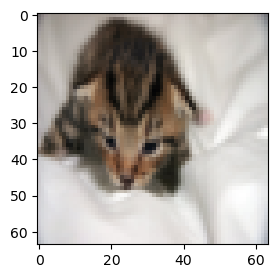

y = 1, you predicted that it is a cat picture.


In [23]:
# Example of a picture that was wrongly classified.
index = 2
plt.figure(figsize=(3,3))
plt.imshow(test_set_x_orig[index, :, :, :])

println("y = " * string(test_set_y[index]) * ", you predicted that it is a " * 
    classes[Int(d["Y_prediction_test"][index]) + 1] *  " picture.")

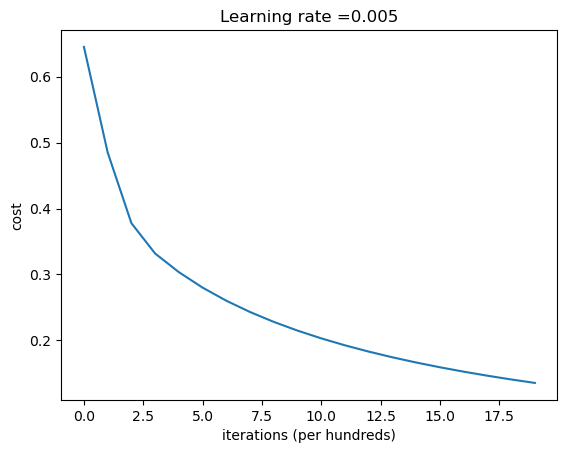

In [24]:
costs = d["costs"]
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate =" * string(d["learning_rate"]))
plt.show()

**Interpretation**:
You can see the cost decreasing. It shows that the parameters are being learned. However, you see that you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting. 

## 6 - Further Analysis (optional/ungraded exercise) 

Congratulations on building your first image classification model. Let's analyze it further, and examine possible choices for the learning rate $\alpha$. 

### Choice of learning rate

**Reminder**:
In order for Gradient Descent to work you must choose the learning rate wisely. The learning rate $\alpha$  determines how rapidly we update the parameters. If the learning rate is too large we may "*overshoot*" the optimal value. Similarly, if it is too small we will need *too many iterations* to converge to the best values. That's why it is crucial to use a well-tuned learning rate.

Let's compare the learning curve of our model with several choices of learning rates. Run the cell below. This should take about 1 minute. Feel free also to try different values than the three we have initialized the `learning_rates` variable to contain, and see what happens. 

learning rate is: 0.01
train accuracy: 99.521531%
test accuracy: 68.000000%
-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.995215%
test accuracy: 64.000000%
-------------------------------------------------------

learning rate is: 0.0001


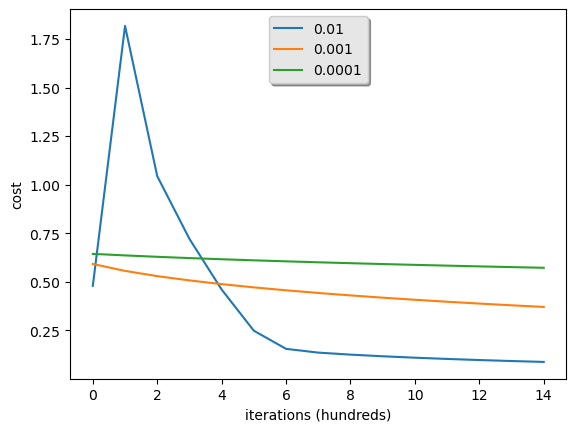

train accuracy: 68.421053%
test accuracy: 36.000000%
-------------------------------------------------------



In [25]:
learning_rates = [0.01, 0.001, 0.0001]
models = Dict()

for i in learning_rates
    println("learning rate is: " * string(i))
    models[string(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, 1500, i, false)
    println("\n" * "-------------------------------------------------------" * "\n")
end

for i in learning_rates
    plt.plot(models[string(i)]["costs"], label= string(models[string(i)]["learning_rate"]))
end

plt.ylabel("cost")
plt.xlabel("iterations (hundreds)")

legend = plt.legend(loc="upper center", shadow=true)
frame = legend.get_frame()
frame.set_facecolor("0.90")
plt.show()

**Interpretation**: 
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large ($0.01$), the cost may *oscillate up and down.* It may even *diverge* (though in this example, using $0.01$ still eventually ends up at a good value for the cost). 
- A lower cost doesn't mean a better model. You have to check if there is possibly *overfitting*. It happens when the training accuracy is a lot higher than the test accuracy.
- In deep learning, we usually recommend that you: 
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting. (We'll talk about this in later videos.) 

## 7 - Test with Your Own Image (optional/ungraded exercise) 

Congratulations on finishing this assignment. You can use your own image and see the output of your model. To do that:
1. Click on "File" in the upper bar of this notebook, then click "Open" to go to the current folder.
2. Add your image to this Jupyter Notebook's directory, in the "images" folder
3. Change your image's name in the following code
4. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

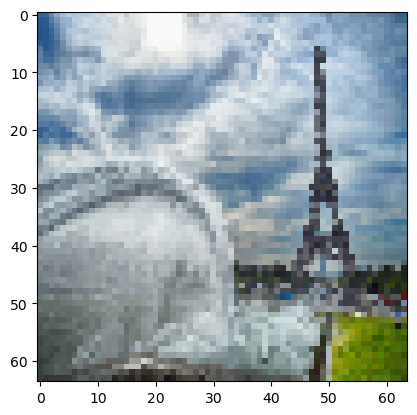

y = 0, your algorithm predicts a non-cat picture.


In [26]:
using Images, ImageTransformations, FileIO
## START CODE HERE ## (PUT YOUR IMAGE NAME) 
my_image = "my_image.jpg"   # change this to the name of your image file 
## END CODE HERE ##

# We preprocess the image to fit your algorithm.
fname = "images/" * my_image
image = load(fname)
image = imresize(image, (num_px, num_px))
image = channelview(image)
image = permutedims(image, [2,3,1])
plt.imshow(image)

image = image/255
my_image = permutedims(reshape(image, (num_px*num_px, 3)), [2,1])
my_image = reshape(my_image, (num_px*num_px*3, 1))
my_predicted_image = predict(d["w"], d["b"], my_image)
println("y = " * string(Int(my_predicted_image[1])) * ", your algorithm predicts a " *
      classes[Int(my_predicted_image[1]) + 1] *  " picture.")

<font color='blue'>
    
**What to remember from this assignment:**
1. Preprocessing the dataset is important.
2. You implemented each function separately: ```initialize()```, ```propagate()```, ```optimize()```. Then you built a ```model()```.
3. Tuning the learning rate (which is an example of a "hyperparameter") can make a big difference to the algorithm. You will see more examples of this later in this course!

Finally, if you'd like, we invite you to try different things on this Notebook. Make sure you submit before trying anything. Once you submit, things you can play with include:
- Play with the learning rate and the number of iterations
- Try different initialization methods and compare the results
- Test other preprocessings (center the data, or divide each row by its standard deviation)

Bibliography:
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/
- https://stats.stackexchange.com/questions/211436/why-do-we-normalize-images-by-subtracting-the-datasets-image-mean-and-not-the-c